<a href="https://www.kaggle.com/code/chittepurohithreddy/breast-cancer-classification-deeplearning?scriptVersionId=139220080" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa

from keras.utils import plot_model
from imblearn.over_sampling import SMOTE
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from tensorflow.keras.applications import ResNet50V2, VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img,img_to_array

In [2]:
folder = '/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast'
folder_path = pathlib.Path(folder)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=700x460 at 0x7F21A28D2C90>


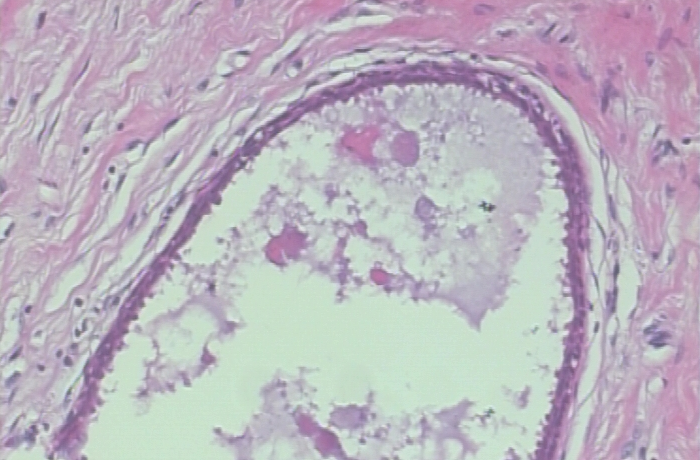

In [3]:
photo = load_img('/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png')
print(photo)
photo

In [4]:
IMG_SIZE = 128
DIM = (IMG_SIZE, IMG_SIZE)

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

In [5]:
train_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
train_data_gen = train_generator.flow_from_directory(directory=folder, target_size=DIM, batch_size=6500, shuffle=False)

Found 7909 images belonging to 2 classes.


In [6]:
train_data, train_labels = train_data_gen.next()

In [7]:
#Synthetic Minority Over-sampling Technique
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

print(train_data.shape, train_labels.shape)

(8040, 49152) (8040, 1)


In [8]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(8040, 128, 128, 3) (8040, 1)


In [9]:
train_labels = train_labels.reshape(-1, 1)

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


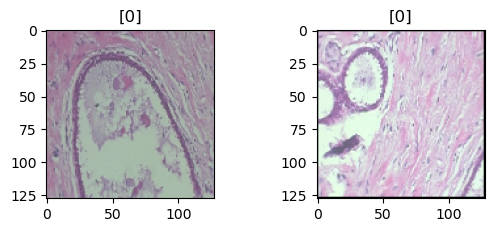

In [10]:
for i in range(2):
    plt.subplot(2,2,1+i)
    plt.title(train_labels[i])
    plt.imshow(train_data[i])

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels,val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [13]:
from keras.layers import MaxPool2D


act = 'relu'
IMAGE_SIZE = (128, 128)

cnn_model = Sequential([
Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
Conv2D(16, 3, activation=act, padding='same'),
Conv2D(16, 3, activation=act, padding='same'),
BatchNormalization(),
MaxPool2D(),
Conv2D(32, 3, activation=act, padding='same'),
Conv2D(32, 3, activation=act, padding='same'),
BatchNormalization(),
MaxPool2D(),
Conv2D(64, 3, activation=act, padding='same'),
Conv2D(64, 3, activation=act, padding='same'),
Conv2D(64, 3, activation=act, padding='same'),
BatchNormalization(),
MaxPool2D(),
Dropout(0.2),
Conv2D(128, 3, activation=act, padding='same'),
Conv2D(128, 3, activation=act, padding='same'),
Conv2D(128, 3, activation=act, padding='same'),
BatchNormalization(),
    MaxPool2D(),
Dropout(0.2),
Conv2D(256, 3, activation=act, padding='same'),
Conv2D(256, 3, activation=act, padding='same'),
Conv2D(256, 3, activation=act, padding='same'),
BatchNormalization(),
MaxPool2D(),
Dropout(0.2),
Flatten(),
Dense(512, activation=act),
BatchNormalization(),
Dropout(0.7),
Dense(128, activation=act),
BatchNormalization(),
Dropout(0.5),
Dense(64, activation=act),
BatchNormalization(),
Dropout(0.3),
Dense(1, activation='sigmoid')
], name='cnn_model')

In [14]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        92

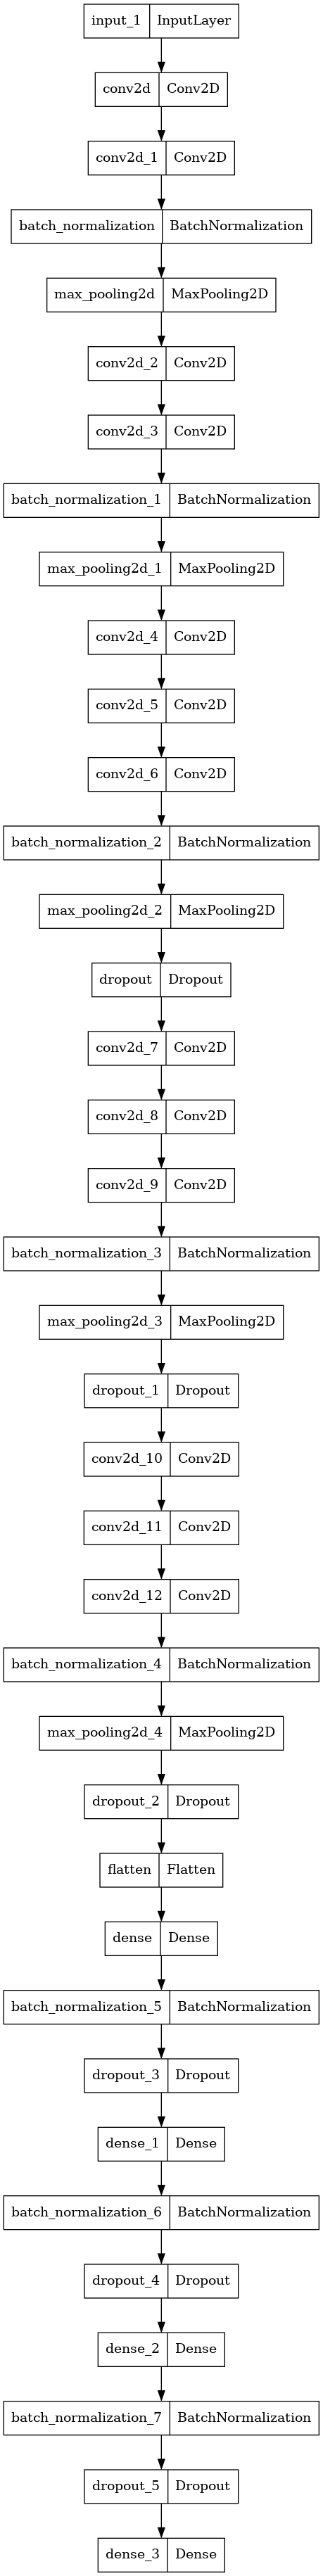

In [15]:
plot_model(cnn_model)

In [16]:
tf.keras.backend.set_image_data_format('channels_first')

In [17]:
# Fit the model to the training data
history = cnn_model.fit(train_data, train_labels, epochs=50, verbose=1)

# Store accuracy and loss history for each epoch
cnn_accuracy_history = history.history['accuracy']
cnn_loss_history = history.history['loss']

Epoch 1/50


2023-08-07 19:35:22.714035: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incnn_model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


161/161 [==============================] - 26s 46ms/step - loss: 0.6353 - accuracy: 0.7007
Epoch 2/50
161/161 [==============================] - 7s 41ms/step - loss: 0.4777 - accuracy: 0.7784
Epoch 3/50
161/161 [==============================] - 7s 41ms/step - loss: 0.4217 - accuracy: 0.8023
Epoch 4/50
161/161 [==============================] - 7s 41ms/step - loss: 0.4090 - accuracy: 0.8084
Epoch 5/50
161/161 [==============================] - 7s 42ms/step - loss: 0.4020 - accuracy: 0.8119
Epoch 6/50
161/161 [==============================] - 7s 41ms/step - loss: 0.3908 - accuracy: 0.8297
Epoch 7/50
161/161 [==============================] - 7s 42ms/step - loss: 0.3777 - accuracy: 0.8389
Epoch 8/50
161/161 [==============================] - 7s 42ms/step - loss: 0.3719 - accuracy: 0.8338
Epoch 9/50
161/161 [==============================] - 7s 41ms/step - loss: 0.3577 - accuracy: 0.8468
Epoch 10/50
161/161 [==============================] - 7s 43ms/step - loss: 0.3472 - accuracy: 0.8542

In [18]:
loss, accuracy = cnn_model.evaluate(test_data, test_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

51/51 [==============================] - 1s 16ms/step - loss: 0.3230 - accuracy: 0.8725
Accuracy: 87.25%


In [19]:
y_pred = np.round(cnn_model.predict(test_data)).astype(int)

target_names = ['Benign', 'Malignant']
report = classification_report(test_labels, y_pred, target_names=target_names, output_dict=True)

for target_name in target_names:
    precision = report[target_name]['precision']
    recall = report[target_name]['recall']
    f1_score = report[target_name]['f1-score']
  
# Average precision, recall, and F1-score
avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1_score = report['weighted avg']['f1-score']

print('Average Precision: {:.2f}%'.format(avg_precision*100))
print('Average Recall: {:.2f}%'.format(avg_recall*100))
print('Average F1 Score: {:.2f}%'.format(avg_f1_score*100))

cnn_precision = avg_precision
cnn_recall = avg_recall
cnn_f1score = avg_f1_score

51/51 [==============================] - 1s 11ms/step
Average Precision: 87.67%
Average Recall: 87.25%
Average F1 Score: 87.20%


51/51 [==============================] - 0s 9ms/step


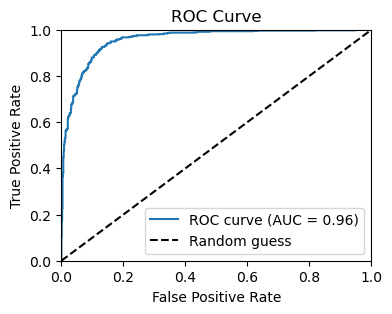

In [20]:
# Get predicted probabilities for test set
y_pred_prob = cnn_model.predict(test_data)

# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)

# Compute AUC score
roc_auc = roc_auc_score(test_labels, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

51/51 [==============================] - 0s 9ms/step


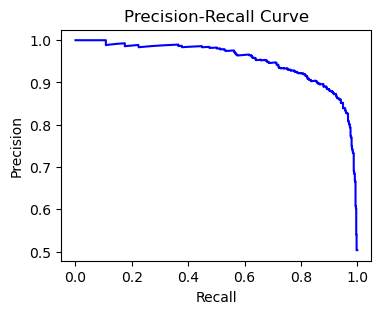

In [21]:
y_scores = cnn_model.predict(test_data)
precision, recall, _ = precision_recall_curve(test_labels, y_scores)

plt.figure(figsize=(4,3)) # set figure size
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

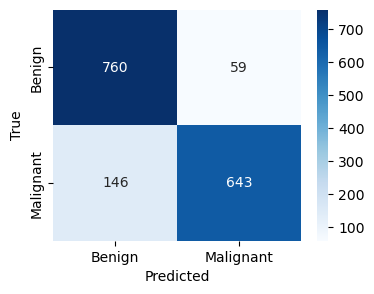

In [22]:
# your code here
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
from keras import backend as K

K.set_image_data_format('channels_last')
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [24]:
for layer in vgg_model.layers:
    layer.trainable = False

In [25]:
vgg16_model = Sequential([
    vgg_model,
    Flatten(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')        
], name="vgg16_model")

In [26]:
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vgg16_model.summary()

Model: "vgg16_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_8 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 512)               

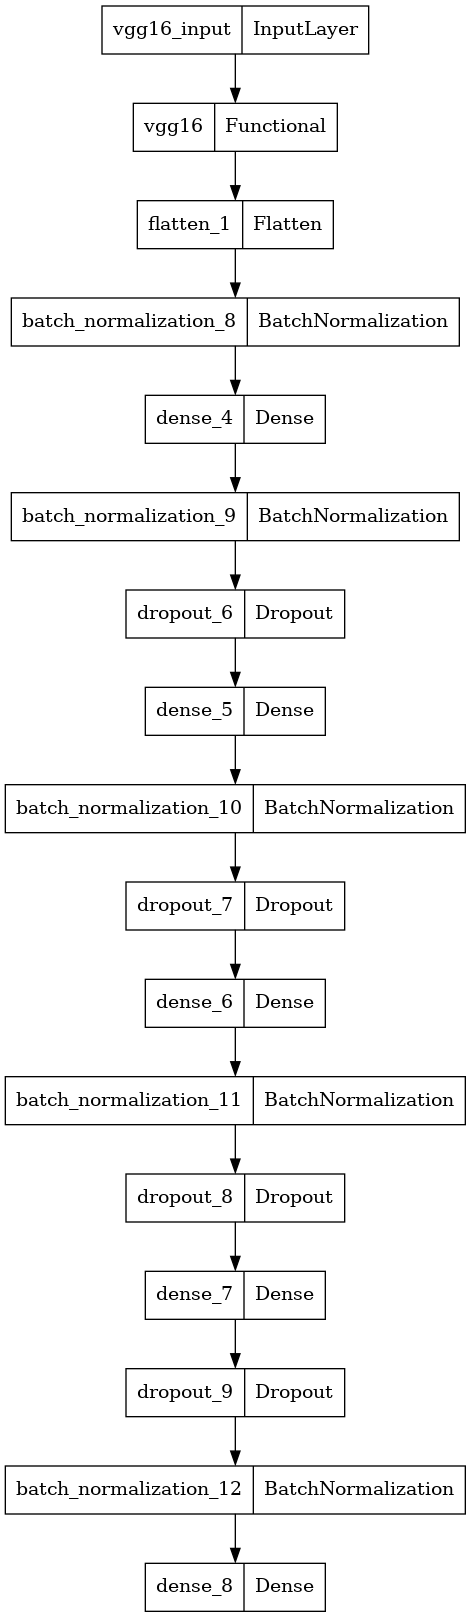

In [27]:
plot_model(vgg16_model)

In [28]:
# Fit the model to the training data
vgg16_history = vgg16_model.fit(train_data, train_labels, epochs=50, verbose=1)

# Store accuracy and loss history for each epoch
vgg16_accuracy_history = vgg16_history.history['accuracy']
vgg16_loss_history = vgg16_history.history['loss']

Epoch 1/50
161/161 [==============================] - 16s 55ms/step - loss: 0.7469 - accuracy: 0.5911
Epoch 2/50
161/161 [==============================] - 7s 43ms/step - loss: 0.5596 - accuracy: 0.7230
Epoch 3/50
161/161 [==============================] - 7s 45ms/step - loss: 0.4514 - accuracy: 0.7979
Epoch 4/50
161/161 [==============================] - 7s 44ms/step - loss: 0.3792 - accuracy: 0.8332
Epoch 5/50
161/161 [==============================] - 7s 43ms/step - loss: 0.3402 - accuracy: 0.8601
Epoch 6/50
161/161 [==============================] - 7s 44ms/step - loss: 0.2922 - accuracy: 0.8820
Epoch 7/50
161/161 [==============================] - 7s 44ms/step - loss: 0.2564 - accuracy: 0.8989
Epoch 8/50
161/161 [==============================] - 7s 44ms/step - loss: 0.2363 - accuracy: 0.9088
Epoch 9/50
161/161 [==============================] - 7s 44ms/step - loss: 0.2008 - accuracy: 0.9230
Epoch 10/50
161/161 [==============================] - 7s 44ms/step - loss: 0.1980 - accur

In [29]:
loss, accuracy = vgg16_model.evaluate(test_data, test_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

51/51 [==============================] - 3s 60ms/step - loss: 0.5379 - accuracy: 0.8507
Accuracy: 85.07%


In [30]:
y_pred = np.round(vgg16_model.predict(test_data)).astype(int)

target_names = ['Benign', 'Malignant']
report = classification_report(test_labels, y_pred, target_names=target_names, output_dict=True)

for target_name in target_names:
    precision = report[target_name]['precision']
    recall = report[target_name]['recall']
    f1_score = report[target_name]['f1-score']
  
# Average precision, recall, and F1-score
avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1_score = report['weighted avg']['f1-score']

print('Average Precision: {:.2f}%'.format(avg_precision*100))
print('Average Recall: {:.2f}%'.format(avg_recall*100))
print('Average F1 Score: {:.2f}%'.format(avg_f1_score*100))

vgg16_precision = avg_precision
vgg16_recall = avg_recall
vgg16_f1score = avg_f1_score

51/51 [==============================] - 2s 42ms/step
Average Precision: 85.11%
Average Recall: 85.07%
Average F1 Score: 85.06%


51/51 [==============================] - 2s 42ms/step


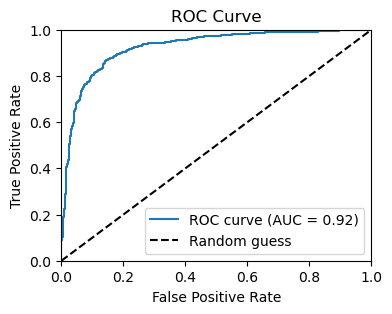

In [31]:
# Get predicted probabilities for test set
y_pred_prob_tl = vgg16_model.predict(test_data)

# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob_tl)

# Compute AUC score
roc_auc = roc_auc_score(test_labels, y_pred_prob_tl)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

51/51 [==============================] - 2s 43ms/step


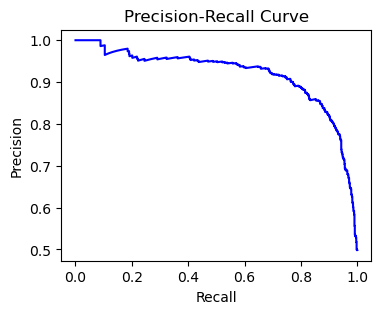

In [32]:
y_scores = vgg16_model.predict(test_data)
precision, recall, _ = precision_recall_curve(test_labels, y_scores)

plt.figure(figsize=(4,3)) # set figure size
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [33]:
# Load the pre-trained ResNet50V2 model
resnet50v2 = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Freeze the layers in the pre-trained model
for layer in resnet50v2.layers:
    layer.trainable = False

94668760/94668760 [==============================] - 1s 0us/step


In [34]:
ResNet50V2_model = Sequential([
    resnet50v2,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
], name="ResNet50V2_model")

In [35]:
ResNet50V2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ResNet50V2_model.summary()

Model: "ResNet50V2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               16777728  
                                                                 
 batch_normalization_13 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                  

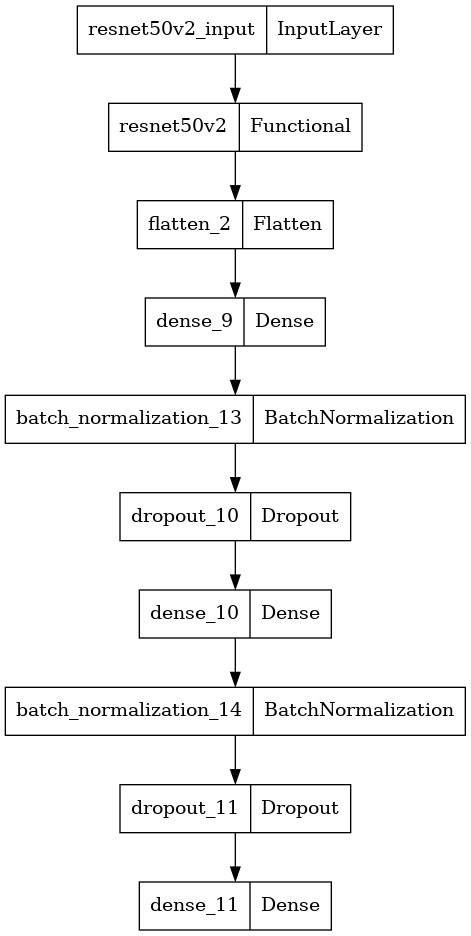

In [36]:
plot_model(ResNet50V2_model)

In [37]:
ResNet50V2_model_history = ResNet50V2_model.fit(train_data, train_labels, epochs=50, verbose=1)

# Store accuracy and loss history for each epoch
ResNet_accuracy_history = ResNet50V2_model_history.history['accuracy']
ResNet_loss_history = ResNet50V2_model_history.history['loss']

Epoch 1/50
161/161 [==============================] - 13s 41ms/step - loss: 0.6042 - accuracy: 0.7409
Epoch 2/50
161/161 [==============================] - 6s 37ms/step - loss: 0.3883 - accuracy: 0.8338
Epoch 3/50
161/161 [==============================] - 6s 37ms/step - loss: 0.2762 - accuracy: 0.8865
Epoch 4/50
161/161 [==============================] - 6s 37ms/step - loss: 0.2009 - accuracy: 0.9188
Epoch 5/50
161/161 [==============================] - 6s 37ms/step - loss: 0.1632 - accuracy: 0.9337
Epoch 6/50
161/161 [==============================] - 6s 37ms/step - loss: 0.1318 - accuracy: 0.9481
Epoch 7/50
161/161 [==============================] - 6s 37ms/step - loss: 0.1222 - accuracy: 0.9530
Epoch 8/50
161/161 [==============================] - 6s 38ms/step - loss: 0.1007 - accuracy: 0.9615
Epoch 9/50
161/161 [==============================] - 6s 37ms/step - loss: 0.1002 - accuracy: 0.9631
Epoch 10/50
161/161 [==============================] - 6s 37ms/step - loss: 0.0864 - accur

In [38]:
loss, accuracy = ResNet50V2_model.evaluate(test_data, test_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

51/51 [==============================] - 4s 46ms/step - loss: 0.7408 - accuracy: 0.8383
Accuracy: 83.83%


In [39]:
y_pred = np.round(ResNet50V2_model.predict(test_data)).astype(int)

target_names = ['Benign', 'Malignant']
report = classification_report(test_labels, y_pred, target_names=target_names, output_dict=True)

for target_name in target_names:
    precision = report[target_name]['precision']
    recall = report[target_name]['recall']
    f1_score = report[target_name]['f1-score']
  
# Average precision, recall, and F1-score
avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1_score = report['weighted avg']['f1-score']

print('Average Precision: {:.2f}%'.format(avg_precision*100))
print('Average Recall: {:.2f}%'.format(avg_recall*100))
print('Average F1 Score: {:.2f}%'.format(avg_f1_score*100))

ResNet_precision = avg_precision
ResNet_recall = avg_recall
ResNet_f1score = avg_f1_score

51/51 [==============================] - 3s 32ms/step
Average Precision: 84.19%
Average Recall: 83.83%
Average F1 Score: 83.77%


51/51 [==============================] - 2s 33ms/step


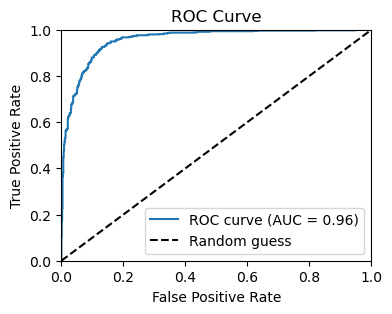

In [40]:
# Get predicted probabilities for test set
y_pred = ResNet50V2_model.predict(test_data)

# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)

# Compute AUC score
roc_auc = roc_auc_score(test_labels, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

51/51 [==============================] - 2s 33ms/step


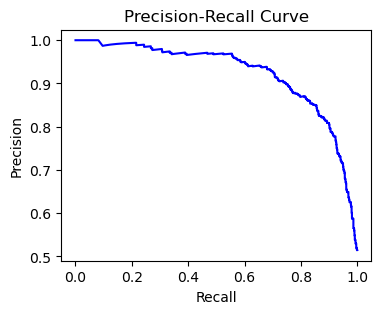

In [41]:
y_scores = ResNet50V2_model.predict(test_data)
precision, recall, _ = precision_recall_curve(test_labels, y_scores)

plt.figure(figsize=(4,3)) # set figure size
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

#  **Model Evaluation**

In [42]:
# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_data, test_labels)

# Evaluate the VGG16 model
vgg16_loss, vgg16_accuracy = vgg16_model.evaluate(test_data, test_labels)

# Evaluate the ResNet50V2 model
resnet_loss, resnet_accuracy = ResNet50V2_model.evaluate(test_data, test_labels)

print('+-------------------------------------------------------+')
print('|{"Model Evaluation Results"} |   {"loss"} | {"accuracy"}             |')
print('+-----------------+---------------+---------------------+')
print(f'|    {"CNN Model":<15} |    {cnn_loss:.2f}      |        {cnn_accuracy:.2f}        |')
print('+-----------------+---------------+---------------------+')


print(f'|   {"VGG16 Model":<15} |    {vgg16_loss:.2f}      |        {vgg16_accuracy:.2f}        |')
print('+-----------------+---------------+---------------------+')


print(f'| {"ResNet50V2 Model":<15} |    {resnet_loss:.2f}      |        {resnet_accuracy:.2f}         |')
print('+-----------------+---------------+---------------------+')


51/51 [==============================] - 2s 34ms/step - loss: 0.7408 - accuracy: 0.8383
+-------------------------------------------------------+
|{"Model Evaluation Results"} |   {"loss"} | {"accuracy"}             |
+-----------------+---------------+---------------------+
|    CNN Model       |    0.32      |        0.87        |
+-----------------+---------------+---------------------+
|   VGG16 Model     |    0.54      |        0.85        |
+-----------------+---------------+---------------------+
| ResNet50V2 Model |    0.74      |        0.84         |
+-----------------+---------------+---------------------+


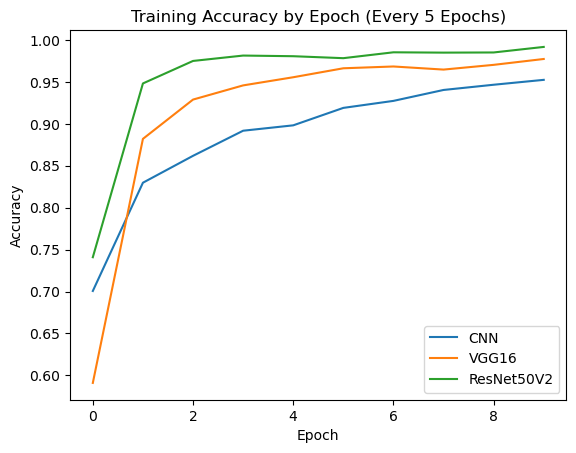

In [43]:
# Extract the accuracy history for each model every 5 epochs
cnn_history = cnn_accuracy_history[::5]
vgg16_history = vgg16_accuracy_history[::5]
resnet_history = ResNet_accuracy_history[::5]

# Plot the accuracy history for each model
plt.plot(cnn_history, label='CNN')
plt.plot(vgg16_history, label='VGG16')
plt.plot(resnet_history, label='ResNet50V2')

# Set the plot title and axis labels
plt.title('Training Accuracy by Epoch (Every 5 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

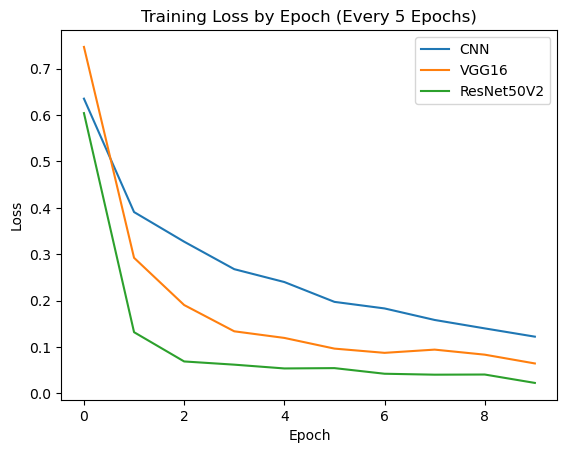

In [44]:
# Extract the loss history for each model every 5 epochs
cnn_history = cnn_loss_history[::5]
vgg16_history = vgg16_loss_history[::5]
resnet_history = ResNet_loss_history[::5]

# Plot the loss history for each model
plt.plot(cnn_history, label='CNN')
plt.plot(vgg16_history, label='VGG16')
plt.plot(resnet_history, label='ResNet50V2')

# Set the plot title and axis labels
plt.title('Training Loss by Epoch (Every 5 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [45]:
# Create a dictionary to store the metrics
metrics_dict = {
    'Model': ['CNN', 'VGG16', 'ResNet50V2'],
   'Avg Precision': [cnn_precision*100, vgg16_precision*100, ResNet_precision*100],
        'Avg Recall': [cnn_recall*100, vgg16_recall*100, ResNet_recall*100],
        'Avg F1-Score': [cnn_f1score*100, vgg16_f1score*100, ResNet_f1score*100]
}

# Create a pandas DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_dict)

# Print the DataFrame
print(metrics_df)

        Model  Avg Precision  Avg Recall  Avg F1-Score
0         CNN      87.668402   87.251244     87.200789
1       VGG16      85.113192   85.074627     85.064222
2  ResNet50V2      84.191345   83.830846     83.768136
